이거 내가 한 거 아닌데 누구지?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import soundfile as sf

def check_and_process_files(path, min_duration=1.0, max_duration=10.0, target_sr=22050):
    # 주어진 경로와 그 하위 경로에서 wav 파일들을 찾습니다.
    audio_files = glob.glob(os.path.join(path, '**/*.wav'), recursive=True)

    small_files = []
    for audio_file in audio_files:
        # 파일의 길이를 확인합니다.
        signal, sr = librosa.load(audio_file)
        duration = librosa.get_duration(y=signal, sr=sr)  # 수정된 부분

        # 너무 짧은 파일들은 리스트에 추가합니다.
        if duration < min_duration:
            small_files.append(audio_file)
            continue

        # 너무 긴 파일들은 잘라서 저장합니다.
        if duration > max_duration:
            signal = librosa.resample(signal, orig_sr=sr, target_sr=target_sr)  # 수정된 부분
            signal = signal[:int(max_duration * target_sr)]
            sf.write(audio_file, signal, target_sr)

    # 너무 짧은 파일들의 이름을 출력합니다.
    print('Small files:', small_files)

check_and_process_files('/content/drive/MyDrive/음성데이터셋/03fin48_ai_koen_padding_cut_no_noise')
check_and_process_files('/content/drive/MyDrive/음성데이터셋/03fin48_human_koen_padding_cut_no_noise')


Small files: []
Small files: []


In [ ]:
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import glob
import os

def get_files_from_dir(path, file_format):
    # 주어진 경로와 그 하위 경로에서 특정 형식의 파일들을 찾습니다.
    return glob.glob(os.path.join(path, f'**/*.{file_format}'), recursive=True)

# 데이터 증강 함수
def augment_data(y, sr):
    y_changed = librosa.effects.time_stretch(y, rate=0.81)
    y_changed = librosa.effects.pitch_shift(y_changed, sr=sr, n_steps=4)

    return y_changed

def extract_features(audio_files):
    features = []

    for audio_file in audio_files:
        try:
            y,sr=librosa.load(audio_file)

            # 원본 데이터에 대한 특성 추출
            mfccs = librosa.feature.mfcc(y=y,sr=sr)
            chroma_stft=librosa.feature.chroma_stft(y=y,sr=sr)
            spectral_contrast=librosa.feature.spectral_contrast(y=y,sr=sr)

            original_features=np.concatenate((np.mean(mfccs,axis=1),np.mean(chroma_stft,axis=1),np.mean(spectral_contrast,axis=1)))

            features.append(original_features)

            # 증강된 데이터에 대한 특성 추출
            y_augmented = augment_data(y,sr)

            mfccs_augmented=librosa.feature.mfcc(y=y_augmented,sr=sr)
            chroma_stft_augmented=librosa.feature.chroma_stft(y=y_augmented,sr=sr)
            spectral_contrast_augmented=librosa.feature.spectral_contrast(y=y_augmented,sr=sr)


            augmented_features=np.concatenate((np.mean(mfccs_augmented,axis=1),np.mean(chroma_stft_augmented,axis=1),np.mean(spectral_contrast_augmented,axis=-1)))

            features.append(augmented_features)

        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")

    return np.array(features)


ai_audio_files=get_files_from_dir('/content/drive/MyDrive/음성데이터셋/03fin48_ai_koen_padding_cut_no_noise', 'wav')
human_audio_files=get_files_from_dir('/content/drive/MyDrive/음성데이터셋/03fin48_human_koen_padding_cut_no_noise', 'wav')

# AI 음성 특징 추출 및 레이블 생성
ai_features_train_test_fullset=extract_features(ai_audio_files)
ai_labels_train_test_fullset=np.zeros(len(ai_features_train_test_fullset))

# 사람 음성 특징 추출 및 레이블 생성
human_features_train_test_fullset=extract_features(human_audio_files)
human_labels_train_test_fullset=np.ones(len(human_features_train_test_fullset))

X_train,X_val,y_train,y_val=train_test_split(np.concatenate([ai_features_train_test_fullset,human_features_train_test_fullset]),
                                             np.concatenate([ai_labels_train_test_fullset,human_labels_train_test_fullset]),test_size=0.2)

# 원-핫 인코딩을 위해 y 값을 변환
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)


In [ ]:
#혜승이가 짠 마지막 모델+특징 6개에다가 더 추가한ver + 앙상블 기법 추가
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import glob
import os

def get_files_from_dir(path, file_format):
    # 주어진 경로와 그 하위 경로에서 특정 형식의 파일들을 찾습니다.
    return glob.glob(os.path.join(path, f'**/*.{file_format}'), recursive=True)

# 데이터 증강 함수
def augment_data(y, sr):
    y_changed = librosa.effects.time_stretch(y, rate=0.81)
    y_changed = librosa.effects.pitch_shift(y_changed, sr=sr, n_steps=4)

    return y_changed

count = 0

def extract_features(audio_files):
    global count
    features = []

    for audio_file in audio_files:
        try:
            y, sr = librosa.load(audio_file)
            # n_fft 초기값 설정
            n_fft = 1024

            if len(y) < 1024:
                # 방법 1: 신호를 n_fft의 길이로 패딩
                y = np.pad(y, (0, 1024 - len(y)), 'constant')

                # 방법 2: n_fft 값을 입력 신호의 길이에 맞게 조정
                n_fft = len(y)

            # 원본 데이터에 대한 특성 추출
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft)
            chroma_stft=librosa.feature.chroma_stft(y=y,sr=sr)
            spectral_contrast=librosa.feature.spectral_contrast(y=y,sr=sr)
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

            # 추가된 특성
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

            original_features=np.concatenate((np.mean(mfccs,axis=1), np.mean(chroma_stft,axis=1),
                                              np.mean(spectral_contrast,axis=1), np.mean(mel_spectrogram,axis=1),
                                              np.mean(spectral_rolloff,axis=1), np.mean(zero_crossing_rate,axis=1),
                                              np.mean(spectral_centroid,axis=1), np.mean(spectral_bandwidth,axis=1),
                                              np.mean(tonnetz,axis=1)))

            features.append(original_features)

            # 증강된 데이터에 대한 특성 추출
            y_augmented = augment_data(y,sr)

            mfccs_augmented=librosa.feature.mfcc(y=y_augmented,sr=sr)
            chroma_stft_augmented=librosa.feature.chroma_stft(y=y_augmented,sr=sr)
            spectral_contrast_augmented=librosa.feature.spectral_contrast(y=y_augmented,sr=sr)
            mel_spectrogram_augmented = librosa.feature.melspectrogram(y=y_augmented, sr=sr)
            spectral_rolloff_augmented = librosa.feature.spectral_rolloff(y=y_augmented, sr=sr)
            zero_crossing_rate_augmented = librosa.feature.zero_crossing_rate(y_augmented)

            # 추가된 특성
            spectral_centroid_augmented = librosa.feature.spectral_centroid(y=y_augmented, sr=sr)
            spectral_bandwidth_augmented = librosa.feature.spectral_bandwidth(y=y_augmented, sr=sr)
            tonnetz_augmented = librosa.feature.tonnetz(y=librosa.effects.harmonic(y_augmented), sr=sr)

            augmented_features=np.concatenate((np.mean(mfccs_augmented,axis=1),np.mean(chroma_stft_augmented,axis=1),
                                               np.mean(spectral_contrast_augmented,axis=1), np.mean(mel_spectrogram_augmented,axis=1),
                                               np.mean(spectral_rolloff_augmented,axis=1), np.mean(zero_crossing_rate_augmented,axis=1),
                                               np.mean(spectral_centroid_augmented,axis=1), np.mean(spectral_bandwidth_augmented,axis=1),
                                               np.mean(tonnetz_augmented,axis=1)))

            features.append(augmented_features)

        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")

    return np.array(features)



ai_audio_files=get_files_from_dir('/content/drive/MyDrive/음성데이터셋/03fin48_ai_koen_padding_cut_no_noise', 'wav')
human_audio_files=get_files_from_dir('/content/drive/MyDrive/음성데이터셋/03fin48_human_koen_padding_cut_no_noise', 'wav')

# AI 음성 특징 추출 및 레이블 생성
ai_features_train_test_fullset=extract_features(ai_audio_files)
ai_labels_train_test_fullset=np.zeros(len(ai_features_train_test_fullset))

# 사람 음성 특징 추출 및 레이블 생성
human_features_train_test_fullset=extract_features(human_audio_files)
human_labels_train_test_fullset=np.ones(len(human_features_train_test_fullset))

X_train,X_val,y_train,y_val=train_test_split(np.concatenate([ai_features_train_test_fullset,human_features_train_test_fullset]),
                                             np.concatenate([ai_labels_train_test_fullset,human_labels_train_test_fullset]),test_size=0.2)

# 원-핫 인코딩을 위해 y 값을 변환
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

#제3자 79%나온거

from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.regularizers import l1_l2

# 데이터 차원 재조정
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier

# CRNN 모델 구성 함수
def create_model():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.7))

    model.add(Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.7))

    model.add(Conv1D(512, kernel_size=3, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.7))

    model.add(LSTM(256, return_sequences=True, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(Dropout(0.7))
    model.add(LSTM(128, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(Dropout(0.7))

    model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(Dropout(0.7))
    model.add(Dense(2, activation='softmax'))

    # 모델 컴파일
    optimizer = Adam(lr=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

    return model

# Keras 모델을 사이킷런에서 사용 가능하도록 래핑
wrapped_model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

# 앙상블 모델 구성
ensemble_clf = VotingClassifier(estimators=[('model1', wrapped_model), ('model2', wrapped_model), ('model3', wrapped_model)], voting='soft')

# 앙상블 모델 학습
ensemble_clf.fit(X_train, y_train)

# 앙상블 모델 평가
ensemble_score = ensemble_clf.score(X_val, y_val)
print("Ensemble model accuracy: ", ensemble_score)

# ai 폴더와 human 폴더의 파일 불러오기
ai_test_files=get_files_from_dir('/content/drive/MyDrive/음성데이터셋/test_others/ai/', 'wav')
human_test_files=get_files_from_dir('/content/drive/MyDrive/음성데이터셋/test_others/human/', 'wav')

# 특징 추출
ai_test_features = extract_features(ai_test_files)
human_test_features = extract_features(human_test_files)

# 데이터 차원 재조정 (Conv1D 레이어는 3차원 입력을 기대합니다)
ai_test_features = np.expand_dims(ai_test_features, axis=2)
human_test_features = np.expand_dims(human_test_features, axis=2)

# 예측 수행
ai_predictions = model.predict(ai_test_features)
human_predictions = model.predict(human_test_features)

# 각 예측 결과에서 가장 높은 확률의 클래스 선택
ai_predicted_classes = np.argmax(ai_predictions, axis=1)
human_predicted_classes = np.argmax(human_predictions, axis=1)

# ai 음성 파일들이 어떤 클래스로 예측되었는지 출력
print("AI 음성 파일들의 예측 결과:")
print(ai_predicted_classes)

# human 음성 파일들이 어떤 클래스로 예측되었는지 출력
print("Human 음성 파일들의 예측 결과:")
print(human_predicted_classes)

# ai 클래스(0)와 human 클래스(1)의 정확도 계산
ai_accuracy = np.count_nonzero(ai_predicted_classes == 0) / len(ai_predicted_classes) * 100
human_accuracy = np.count_nonzero(human_predicted_classes == 1) / len(human_predicted_classes) * 100

print(f"AI 음성 파일들이 AI로 예측된 확률: {ai_accuracy}%")
print(f"Human 음성 파일들이 Human으로 예측된 확률: {human_accuracy}%")


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=952
  warnings.warn(


ModuleNotFoundError: ignored

In [ ]:
!pip install pydub
from pydub import AudioSegment
import os

def convert_mp3_to_wav(mp3_files, output_dir):
    for mp3_file in mp3_files:
        # MP3 to WAV conversion
        song = AudioSegment.from_mp3(mp3_file)
        wav_filename = os.path.basename(mp3_file).replace('.mp3', '.wav')
        wav_filepath = os.path.join(output_dir, wav_filename)
        song.export(wav_filepath, format="wav")

# AI 음성 파일 변환
#ai_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/ai_voice/ai/week6/', 'mp3')
#convert_mp3_to_wav(ai_audio_files, '/content/drive/MyDrive/PBL/ai_voice/ai/week6/')

# 사람 음성 파일 변환
human_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/buf/human/week6/', 'mp3')
convert_mp3_to_wav(human_audio_files, '/content/drive/MyDrive/PBL/buf/human/week6/')


NameError: ignored

In [ ]:
import os
import random
from pydub import AudioSegment
import shutil

# 변환할 mp3 파일들이 있는 폴더 경로와 새로운 폴더 경로를 지정하세요.
source_folder = '/content/drive/MyDrive/PBL/ai_voice/human영어_패딩제거ver_755개'
target_folder = '/content/drive/MyDrive/PBL/ai_voice/human2_padding_cut_wav/'

# source_folder에서 mp3 파일만 선택합니다.
mp3_files = [f for f in os.listdir(source_folder) if f.endswith('.mp3')]

# 700개의 무작위 파일 선택 (만약 700개 미만의 파일이 있다면 모두 선택)
selected_files = random.sample(mp3_files, min(700, len(mp3_files)))

for file in selected_files:
    # 각각의 mp3 파일을 wav로 변환 후 target_folder에 저장합니다.
    audio = AudioSegment.from_mp3(os.path.join(source_folder, file))
    audio.export(os.path.join(target_folder, file.replace('.mp3', '.wav')), format='wav')

print(f"{len(selected_files)}개의 mp3 파일을 wav 형식으로 변환하여 {target_folder}에 저장했습니다.")


700개의 mp3 파일을 wav 형식으로 변환하여 /content/drive/MyDrive/PBL/ai_voice/human2_padding_cut_wav/에 저장했습니다.


In [ ]:
import librosa
print(librosa.__version__)

0.10.1


In [ ]:
!pip install --upgrade librosa

In [ ]:
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import glob
import os

def get_files_from_dir(path, file_format):
    # 주어진 경로와 그 하위 경로에서 특정 형식의 파일들을 찾습니다.
    return glob.glob(os.path.join(path, f'**/*.{file_format}'), recursive=True)

# 데이터 증강 함수
def augment_data(y, sr):
    y_changed = librosa.effects.time_stretch(y, rate=0.81)
    y_changed = librosa.effects.pitch_shift(y_changed, sr=sr, n_steps=4)

    return y_changed

def extract_features(audio_files):
    features = []

    for audio_file in audio_files:
        try:
            y,sr=librosa.load(audio_file)

            # 원본 데이터에 대한 특성 추출
            mfccs = librosa.feature.mfcc(y=y,sr=sr)
            chroma_stft=librosa.feature.chroma_stft(y=y,sr=sr)
            spectral_contrast=librosa.feature.spectral_contrast(y=y,sr=sr)

            original_features=np.concatenate((np.mean(mfccs,axis=1),np.mean(chroma_stft,axis=1),np.mean(spectral_contrast,axis=1)))

            features.append(original_features)

            # 증강된 데이터에 대한 특성 추출
            y_augmented = augment_data(y,sr)

            mfccs_augmented=librosa.feature.mfcc(y=y_augmented,sr=sr)
            chroma_stft_augmented=librosa.feature.chroma_stft(y=y_augmented,sr=sr)
            spectral_contrast_augmented=librosa.feature.spectral_contrast(y=y_augmented,sr=sr)


            augmented_features=np.concatenate((np.mean(mfccs_augmented,axis=1),np.mean(chroma_stft_augmented,axis=1),np.mean(spectral_contrast_augmented,axis=-1)))

            features.append(augmented_features)

        except Exception as e:
            print(f"Error processing {audio_file}: {str(e)}")

    return np.array(features)


ai_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/ai_voice/ai2_padding_cut_wav/', 'wav')
human_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/ai_voice/human2_padding_cut_wav/', 'wav')

# AI 음성 특징 추출 및 레이블 생성
ai_features_train_test_fullset=extract_features(ai_audio_files)
ai_labels_train_test_fullset=np.zeros(len(ai_features_train_test_fullset))

# 사람 음성 특징 추출 및 레이블 생성
human_features_train_test_fullset=extract_features(human_audio_files)
human_labels_train_test_fullset=np.ones(len(human_features_train_test_fullset))

X_train,X_val,y_train,y_val=train_test_split(np.concatenate([ai_features_train_test_fullset,human_features_train_test_fullset]),
                                             np.concatenate([ai_labels_train_test_fullset,human_labels_train_test_fullset]),test_size=0.2)

# 원-핫 인코딩을 위해 y 값을 변환
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)


KeyboardInterrupt: ignored

In [ ]:
#아예첨부터새로짠모델&학습 이걸로 해야됨 밑에거말고

# 데이터 차원 재조정 (Conv1D 레이어는 3차원 입력을 기대합니다)
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)

# CNN 모델 구성
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# 최종 출력은 softmax를 사용한 2개 클래스에 대한 확률입니다.
# 두 개 이상의 카테고리가 있으므로 'softmax'를 사용합니다.
# 두 개의 카테고리만 있다면 'sigmoid'도 사용할 수 있습니다.
model.add(Dense(2, activation='softmax'))

# 모델 컴파일
optimizer = Adam(lr=0.0001)
early_stopping_monitor = EarlyStopping(patience=10)

# 분류 문제에서는 일반적으로 'categorical_crossentropy' 손실 함수를 사용합니다.
# optimizer로는 Adam을 사용하였습니다.
# metrics로 정확도('accuracy')를 확인합니다.

model.compile(loss='categorical_crossentropy', optimizer=optimizer ,metrics=['accuracy'])

print(model.summary())

history=model.fit(X_train,y_train,batch_size=64,
                  epochs=100,
                  validation_data=(X_val,y_val),
                  callbacks=[early_stopping_monitor])

# 학습 과정에서의 loss, accuracy, val_loss, val_accuracy 기록
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']
val_loss_history = history.history['val_loss']
val_accuracy_history = history.history['val_accuracy']

# loss, accuracy, val_loss, val_accuracy의 평균 계산
average_loss = sum(loss_history) / len(loss_history)
average_accuracy = sum(accuracy_history) / len(accuracy_history)
average_val_loss = sum(val_loss_history) / len(val_loss_history)
average_val_accuracy = sum(val_accuracy_history) / len(val_accuracy_history)

print(f"평균 loss: {average_loss}")
print(f"평균 accuracy: {average_accuracy}")
print(f"평균 val_loss: {average_val_loss}")
print(f"평균 val_accuracy: {average_val_accuracy}")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 37, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 18, 64)            0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 18, 64)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 8, 128)            0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 8, 128)           

In [ ]:
#ver 5. 모델 재구성
from keras.layers import LSTM

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# 모델 컴파일
optimizer = Adam(learning_rate=0.0001)
early_stopping_monitor = EarlyStopping(patience=10)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping_monitor])

# 학습 과정에서의 loss, accuracy, val_loss, val_accuracy 기록
loss_history = history.history['loss']
accuracy_history = history.history['accuracy']
val_loss_history = history.history['val_loss']
val_accuracy_history = history.history['val_accuracy']

# loss, accuracy, val_loss, val_accuracy의 평균 계산
average_loss = sum(loss_history) / len(loss_history)
average_accuracy = sum(accuracy_history) / len(accuracy_history)
average_val_loss = sum(val_loss_history) / len(val_loss_history)
average_val_accuracy = sum(val_accuracy_history) / len(val_accuracy_history)

print(f"평균 loss: {average_loss}")
print(f"평균 accuracy: {average_accuracy}")
print(f"평균 val_loss: {average_val_loss}")
print(f"평균 val_accuracy: {average_val_accuracy}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 39, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 39, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                

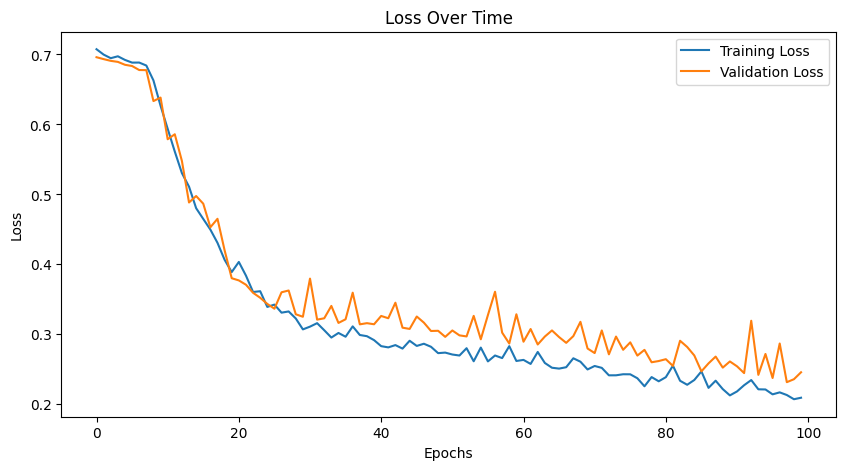

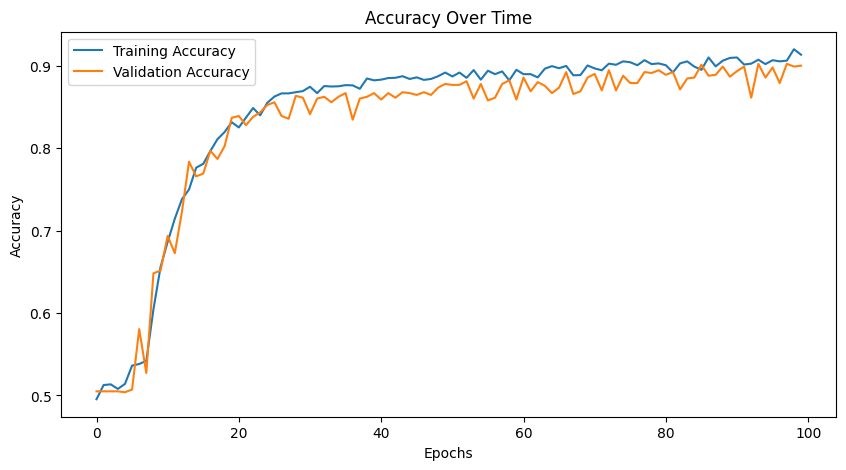

In [ ]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


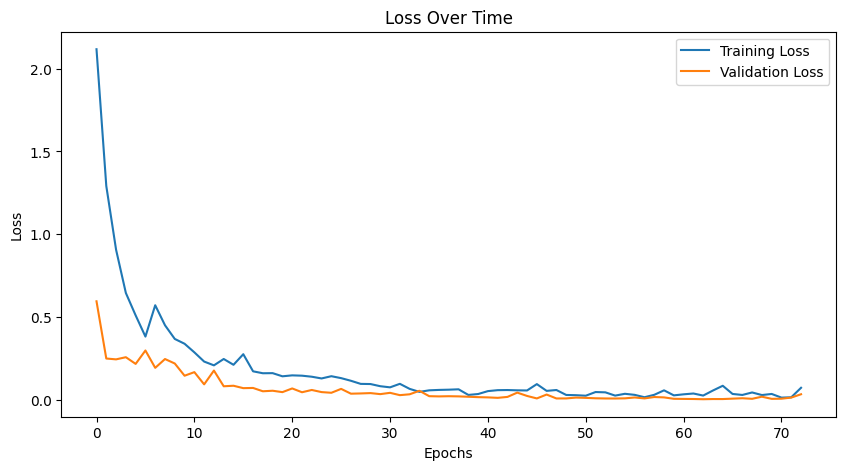

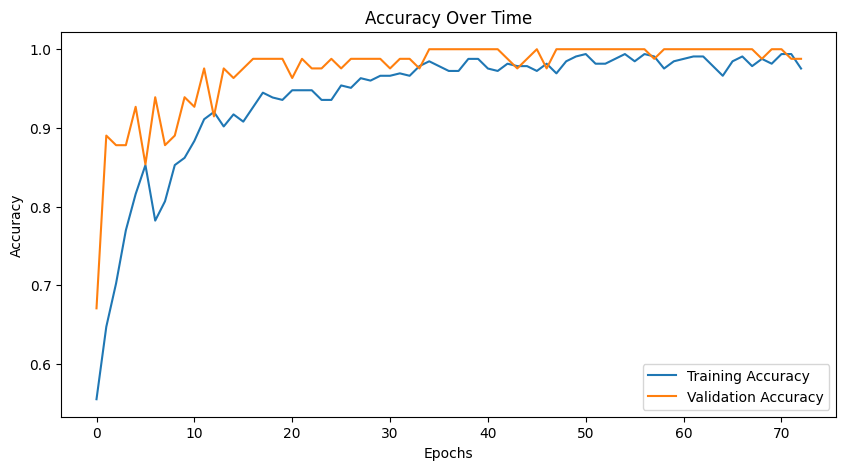

In [ ]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


In [ ]:
ai_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/test_others/ai/', 'wav')
human_audio_files=get_files_from_dir('/content/drive/MyDrive/PBL/test_others/human/', 'wav')

# AI 음성 특징 추출 및 레이블 생성
ai_features_train_test_fullset=extract_features(ai_audio_files)
ai_labels_train_test_fullset=np.zeros(len(ai_features_train_test_fullset))

# 사람 음성 특징 추출 및 레이블 생성
human_features_train_test_fullset=extract_features(human_audio_files)
human_labels_train_test_fullset=np.ones(len(human_features_train_test_fullset))

X_train,X_val,y_train,y_val=train_test_split(np.concatenate([ai_features_train_test_fullset,human_features_train_test_fullset]),
                                             np.concatenate([ai_labels_train_test_fullset,human_labels_train_test_fullset]),test_size=0.2)

# 원-핫 인코딩을 위해 y 값을 변환
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

new_ai_predictions = model.predict(ai_features_train_test_fullset)
new_human_predictions = model.predict(human_features_train_test_fullset)

7/7 [==============================] - 0s 4ms/step


In [ ]:
#ver 5
# 예측 결과를 레이블로 변환 (예: 가장 확률이 높은 클래스를 선택)
from sklearn.metrics import accuracy_score
new_ai_predicted_labels = np.argmax(new_ai_predictions, axis=1)
new_human_predicted_labels = np.argmax(new_human_predictions, axis=1)

# AI로 예측될 확률 계산
ai_accuracy = accuracy_score(ai_labels_train_test_fullset, new_ai_predicted_labels)

# human으로 예측될 확률 계산
human_accuracy = accuracy_score(human_labels_train_test_fullset, new_human_predicted_labels)

# 결과 출력
print("AI로 잘 예측될 확률: {:.2f}%".format(ai_accuracy * 100))
print("사람으로 잘 예측될 확률: {:.2f}%".format(human_accuracy * 100))

AI로 잘 예측될 확률: 100.00%
사람으로 잘 예측될 확률: 25.00%


In [ ]:
#본래 ver
# 예측 결과를 레이블로 변환 (예: 가장 확률이 높은 클래스를 선택)
from sklearn.metrics import accuracy_score
new_ai_predicted_labels = np.argmax(new_ai_predictions, axis=1)
new_human_predicted_labels = np.argmax(new_human_predictions, axis=1)

# AI로 예측될 확률 계산
ai_accuracy = accuracy_score(ai_labels_train_test_fullset, new_ai_predicted_labels)

# human으로 예측될 확률 계산
human_accuracy = accuracy_score(human_labels_train_test_fullset, new_human_predicted_labels)

# 결과 출력
print("AI로 잘 예측될 확률: {:.2f}%".format(ai_accuracy * 100))
print("사람으로 잘 예측될 확률: {:.2f}%".format(human_accuracy * 100))

AI로 잘 예측될 확률: 99.02%
사람으로 잘 예측될 확률: 100.00%


In [ ]:
import os
import librosa
import soundfile as sf

# wav 파일들이 있는 폴더 경로
folder_path = '/content/drive/MyDrive/PBL/ai_voice/ai/week6'

for filename in os.listdir(folder_path):
    if filename.endswith('.wav'):
        # wav 파일 로드
        y, sr = librosa.load(os.path.join(folder_path, filename), sr=None)

        # 발화가 없는 부분 제거
        y_trimmed, index = librosa.effects.trim(y)

        # 변환된 wav 파일 저장 (원래의 이름에 '_trimmed' 추가)
        trimmed_filename = os.path.join(folder_path, os.path.splitext(filename)[0] + '_trimmed.wav')
        sf.write(trimmed_filename, y_trimmed, sr)



In [ ]:
def predict_audio_file(model, audio_file):
    features = []

    try:
        y, sr = librosa.load(audio_file)

        # 원본 데이터에 대한 특성 추출
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        original_features = np.concatenate((np.mean(mfccs,axis=1), np.mean(chroma_stft,axis=1), np.mean(spectral_contrast,axis=1)))

        features.append(original_features)

    except Exception as e:
        print(f"Error processing {audio_file}: {str(e)}")

    # 데이터 차원 재조정 (Conv1D 레이어는 3차원 입력을 기대합니다)
    features = np.expand_dims(features, axis=2)

    # 모델로부터 예측 결과 얻기
    prediction = model.predict(features)

    return prediction

# 제 3자의 음성 파일 경로
test_audio_file = '/content/drive/MyDrive/PBL/ai_voice/human/week6/2.wav'

# 제 3자의 음성 파일에 대한 예측 수행
prediction = predict_audio_file(model, test_audio_file)

# 예측 결과 출력 (각 클래스에 속할 확률)
print(prediction)

# 가장 확률이 높은 클래스 결정 및 출력
predicted_class = np.argmax(prediction)
print(f"Predicted class: {'AI' if predicted_class == 0 else 'Human'}")


In [ ]:
#ver2 아거쓰는거X

from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Dropout,Flatten,Dense,BatchNormalization

# 데이터 차원 재조정 (Conv1D 레이어는 3차원 입력을 기대합니다)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# CNN 모델 구성
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(128,kernel_size=3 ,activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
# 여기서 MaxPooling 층과 Dropout만 사용합니다.
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# 추가 컨볼루션 레이어
model.add(Conv1D(256,kernel_size=3 ,activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
# 마지막 Dropout 비율 조절
model.add(Dropout(0.5))

# Flatten 층은 Convolutional layer와 Dense layer 사이에서 필요합니다.
# Convolutional layer에서 나온 3차원 배열을 Dense layer가 받아들일 수 있는 2차원 형태로 바꿔줍니다.
model.add(Flatten())

# Dense(Fully-Connected) Layer에 들어갑니다.
# 여기서 최종 출력은 softmax를 사용한 2개 클래스에 대한 확률입니다.
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# 최종 출력은 softmax를 사용한 2개 클래스에 대한 확률입니다.
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.0001)
early_stopping_monitor = EarlyStopping(patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

model.compile(loss='categorical_crossentropy', optimizer=optimizer ,metrics=['accuracy'])

#print(model.summary())

history=model.fit(X_train,y_train,batch_size=32,
                  epochs=150,
                  validation_data=(X_val,y_val),
                  callbacks=[early_stopping_monitor, reduce_lr])

In [ ]:
#ver3

from keras.regularizers import l2

# CNN 모델 구성
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3)) # Dropout rate increased to 0.3
model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5)) # Dropout rate increased to 0.5
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
# 최종 출력은 클래스의 수와 같아야 합니다.
# 이 경우에는 '사람의 음성'과 'AI 음성'의 두 가지 클래스가 있으므로 2입니다.
# softmax 활성화 함수를 사용하여 각 클래스에 대한 확률을 출력합니다.
model.add(Dense(2, activation='softmax'))

# 모델 컴파일
opt = Adam(lr=0.001)
early_stopping_monitor = EarlyStopping(patience=30) # Increased patience to 30 epochs
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# 데이터 차원 변경 (Convolution layer는 3차원 데이터를 기대함)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# 학습 진행
history=model.fit(X_train_cnn, y_train,
                  validation_data=(X_val_cnn,y_val),
                  batch_size=32,
                  epochs=100,
                  verbose=True,
                  callbacks=[early_stopping_monitor])



In [ ]:
#ver4
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.005))) # Reduced L2 regularization to 0.005
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4)) # Reduced Dropout rate to 0.4
model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.005))) # Reduced L2 regularization to 0.005
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5)) # Reduced Dropout rate to 0.5
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.005))) # Reduced L2 regularization to 0.005
model.add(Dropout(0.6)) # Reduced Dropout rate to 0

# 최종 출력은 클래스의 수와 같아야 합니다.
# 이 경우에는 '사람의 음성'과 'AI 음성'의 두 가지 클래스가 있으므로 2입니다.
# softmax 활성화 함수를 사용하여 각 클래스에 대한 확률을 출력합니다.
model.add(Dense(2, activation='softmax'))

# 모델 컴파일 (Reduced learning rate to 0.)
opt = Adam(lr=0.001)
early_stopping_monitor = EarlyStopping(patience=40)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# 데이터 차원 변경 (Convolution layer는 3차원 데이터를 기대함)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# 학습 진행 (Batch size changed to 64)
history=model.fit(X_train_cnn, y_train,
                  validation_data=(X_val_cnn,y_val),
                  batch_size=32, # Batch size changed to 64
                  epochs=100,
                  verbose=True,
                  callbacks=[early_stopping_monitor])


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show the plot
plt.tight_layout()

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)